In [1]:
# API KEY SECRET
'53b39f4s8yh1mo24yougo3fx3h0jhehzm67vcsthl4zyzymii3'

# API KEY ID
'c7nn42f3kh67innzws0qb33hd'

# LINK GIT PROYECTO
'https://github.com/soyHenry/DS-PI-ProyectoIndividual'

'https://github.com/soyHenry/DS-PI-ProyectoIndividual'

In [2]:
# For API requests
import requests

# For managing json files
import json

# For processing data
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.dates as mdates
from scipy.signal import find_peaks
from scipy.signal import argrelextrema

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Function to get the data from the API

url = 'https://healthdata.gov/resource/g62h-syeh.json?' 
token = 'c7nn42f3kh67innzws0qb33hd' # personal token

def GetData(url,token):
    hed = {'X-Auth-Token': f'{token}'}
    url = url + '$limit=100000' # Adding limit 100.000 to get all the data
    response = requests.get(url, headers=hed)
    response_jason = json.loads(response.text)
    df = pd.json_normalize(response_jason)
    return df

In [4]:
# Getting the data from the API
df_covid = GetData(url,token)
print(df_covid.shape)

(47909, 134)


In [5]:
# Getting data from csv
# df_covid = pd.read_csv('Covid.csv')
# print(df_covid.shape)

In [6]:
df_covid.tail()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage,staffed_icu_pediatric_patients_confirmed_covid,on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses,previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used,previous_day_admission_pediatric_covid_confirmed_0_4,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_12_17,previous_day_admission_pediatric_covid_confirmed_5_11
47904,ND,2022-02-21T00:00:00.000,0,8,40,12,32,4,50,47,...,44,10,44,1,482,0,0,0,1,0
47905,NH,2022-02-09T00:00:00.000,2,11,17,6,7,17,9,30,...,30,9,30,1,617,0,2,0,0,0
47906,CA,2022-02-23T00:00:00.000,10,141,263,132,248,34,77,406,...,404,944,404,52,4298,6,15,6,6,4
47907,AL,2022-02-06T00:00:00.000,0,8,109,45,50,22,46,114,...,115,44,115,5,892,16,7,0,2,5
47908,IA,2022-02-07T00:00:00.000,5,17,100,7,17,98,5,120,...,120,55,120,5,40,0,2,0,1,1


## PREPROCESSING

In [7]:
# Transforming columns as they are all str type
df_covid = df_covid.apply(pd.to_numeric, errors='ignore') # to numeric
df_covid.iloc[:,1] = pd.to_datetime(df_covid.iloc[:,1]).dt.date # to date

In [8]:
# Checking some columns
print(f'{type(df_covid.state[0])} should be str')
print(f'{type(df_covid.date[0])} should be datetime')
print(f'{type(df_covid.inpatient_beds[0])} should be numeric')

<class 'str'> should be str
<class 'datetime.date'> should be datetime
<class 'numpy.float64'> should be numeric


In [9]:
# sorting values by date
df_covid = df_covid.sort_values(by = ['date'])

# Reseting index
df_covid = df_covid.reset_index(drop = True)

# The requested analysis must include the data up to 01/08/2022 inclusive.
df_covid = df_covid[df_covid['date'] <= date(2022,8,1)]

### Columns we are going to use and what they mean:
+ 'state' : two digit state code
+ 'date' : report date

##### BEDS **GENERAL**
+ 'inpatient_beds' : Reported total number of staffed inpatient beds (includes all ICU beds)
+ 'inpatient_beds_used' : Reported total number of staffed inpatient beds that are occupied
+ 'inpatient_beds_utilization' : Percentage of inpatient beds that are being utilized
+ 'inpatient_beds_used_covid' : Reported patients in an inpatient bed who have suspected or confirmed COVID-19
+ 'inpatient_bed_covid_utilization' : Percentage of total (used/available) inpatient beds currently utilized by patients who have suspected or confirmed COVID-19

##### **ICU** BEDS **ADULTS**
+ 'total_staffed_adult_icu_beds' : Reported total number of staffed inpatient adult ICU beds
+ 'staffed_adult_icu_bed_occupancy' : Reported total number of staffed inpatient adult ICU beds that are occupied
+ 'adult_icu_bed_utilization' : Percentage of staffed adult ICU beds that are being utilized
+ 'staffed_icu_adult_patients_confirmed_covid' : Reported patients currently hospitalized in an adult ICU bed who have confirmed COVID-19
+ 'adult_icu_bed_covid_utilization' : Percentage of total staffed adult ICU beds currently utilized by patients who have suspected or confirmed COVID-19

##### **PEDIATRIC** BEDS
+ 'all_pediatric_inpatient_beds' : Total number of pediatric beds
+ 'all_pediatric_inpatient_bed_occupied' Total number inpatient pediatric beds that are occupied by a patient
+ 'total_pediatric_patients_hospitalized_confirmed_covid' : Reported patients currently hospitalized in a pediatric inpatient bed who have confirmed COVID-19.

##### **ICU** BEDS **PEDIATRIC**
+ 'total_staffed_pediatric_icu_beds' : Total number of pediatric ICU beds
+ 'staffed_pediatric_icu_bed_occupancy' : Total number of pediatric ICU beds occupied by a patient
+ 'staffed_icu_pediatric_patients_confirmed_covid' : Total number of pediatric ICU beds occupied by laboratory confirmed positive COVID-19 patients

##### **CONFIRMED** COVID INPATIENTS
+ 'previous_day_admission_adult_covid_confirmed'
+ 'previous_day_admission_pediatric_covid_confirmed'


##### **CONFIRMED** COVID **ADULT** INPATIENTS **BY AGE**
+ 'previous_day_admission_adult_covid_confirmed_18_19'
+ 'previous_day_admission_adult_covid_confirmed_20_29'
+ 'previous_day_admission_adult_covid_confirmed_30_39'
+ 'previous_day_admission_adult_covid_confirmed_40_49'
+ 'previous_day_admission_adult_covid_confirmed_50_59'
+ 'previous_day_admission_adult_covid_confirmed_60_69'
+ 'previous_day_admission_adult_covid_confirmed_70_79'
+ 'previous_day_admission_adult_covid_confirmed_80'
+ 'previous_day_admission_adult_covid_confirmed_unknown'

##### **CONFIRMED** COVID **PEDIATRIC** INPATIENTS **BY AGE**
+ 'previous_day_admission_pediatric_covid_confirmed_0_4'
+ 'previous_day_admission_pediatric_covid_confirmed_5_11'
+ 'previous_day_admission_pediatric_covid_confirmed_12_17'
+ 'previous_day_admission_pediatric_covid_confirmed_unknown'

##### **COVID DEATHS**
+ 'deaths_covid' : Number of patients with suspected or confirmed COVID-19 who died 

##### GEOCODES
+ 'geocoded_state' : The geocoded centroid of the given state

##### EXTRAS
+ 'percent_of_inpatients_with_covid' : Percentage of inpatient population who have suspected or confirmed COVID-19



In [10]:
# Adding some extra columns

# New patients with confirmed covid (adults and pediatric)
df_covid['total_covid_confirmed'] = df_covid['previous_day_admission_adult_covid_confirmed'] + df_covid['previous_day_admission_pediatric_covid_confirmed']

# Total ICU patients confirmed COVID
df_covid['total_ICU_patients_covid'] = df_covid['staffed_icu_adult_patients_confirmed_covid'] + df_covid['staffed_icu_pediatric_patients_confirmed_covid']

# Questionary
1. Which were the 5 states with the highest hospital occupancy due to COVID? Occupancy criteria for common bed. Consider the number of occupied beds with confirmed patients and take the first 6 months of 2020 as a reference - remember to include the number of agreements in those months (cumulative). Does the age range influence this behavior?

In [11]:
# Firts 6 months of 2020
#df_6_2020 = df_covid[['state','date','inpatient_beds','inpatient_beds_used_covid','previous_day_admission_adult_covid_confirmed_18_19','previous_day_admission_adult_covid_confirmed_20_29','previous_day_admission_adult_covid_confirmed_30_39','previous_day_admission_adult_covid_confirmed_40_49','previous_day_admission_adult_covid_confirmed_50_59','previous_day_admission_adult_covid_confirmed_60_69','previous_day_admission_adult_covid_confirmed_70_79','previous_day_admission_adult_covid_confirmed_80','previous_day_admission_adult_covid_confirmed_unknown','previous_day_admission_pediatric_covid_confirmed_0_4','previous_day_admission_pediatric_covid_confirmed_5_11','previous_day_admission_pediatric_covid_confirmed_12_17','previous_day_admission_pediatric_covid_confirmed_unknown']]
df_6_2020 = df_covid[(df_covid['date'] >= date(2020,1,1)) & (df_covid['date'] <= date(2020,6,30))]

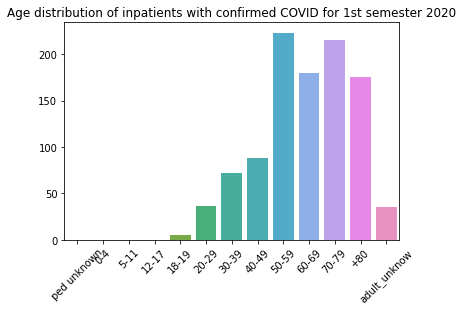

In [12]:
# PARA USAR CON LA API (CAMBIAN LOS NOMBRES DE LAS COLUMNAS)

# Sum of COVID inpatients by age
covid_inpatients = df_6_2020[['previous_day_admission_pediatric_covid_confirmed_unknown','previous_day_admission_pediatric_covid_confirmed_0_4','previous_day_admission_pediatric_covid_confirmed_5_11','previous_day_admission_pediatric_covid_confirmed_12_17','previous_day_admission_adult_covid_confirmed_18_19','previous_day_admission_adult_covid_confirmed_20_29','previous_day_admission_adult_covid_confirmed_30_39','previous_day_admission_adult_covid_confirmed_40_49','previous_day_admission_adult_covid_confirmed_50_59','previous_day_admission_adult_covid_confirmed_60_69','previous_day_admission_adult_covid_confirmed_70_79','previous_day_admission_adult_covid_confirmed_80','previous_day_admission_adult_covid_confirmed_unknown']].sum()
age_labels = np.array(['ped unknown', '0-4', '5-11', '12-17', '18-19','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '+80', 'adult_unknow'])

# Inpatients distribution by AGE between 01/01/2020 and 30/06/2020
sns.barplot(x = age_labels, y = covid_inpatients.values)
plt.xticks(rotation=45)
plt.title('Age distribution of inpatients with confirmed COVID for 1st semester 2020')
plt.show()

In [13]:
# PARA USAR CON EL CSV (CAMBIAN LOS NOMBRES DE LAS COLUMNAS)

# Sum of COVID inpatients by age
# covid_inpatients = df_6_2020[['previous_day_admission_pediatric_covid_confirmed_unknown','previous_day_admission_pediatric_covid_confirmed_0_4','previous_day_admission_pediatric_covid_confirmed_5_11','previous_day_admission_pediatric_covid_confirmed_12_17','previous_day_admission_adult_covid_confirmed_18-19','previous_day_admission_adult_covid_confirmed_20-29','previous_day_admission_adult_covid_confirmed_30-39','previous_day_admission_adult_covid_confirmed_40-49','previous_day_admission_adult_covid_confirmed_50-59','previous_day_admission_adult_covid_confirmed_60-69','previous_day_admission_adult_covid_confirmed_70-79','previous_day_admission_adult_covid_confirmed_80+','previous_day_admission_adult_covid_confirmed_unknown']].sum()
# age_labels = np.array(['ped unknown', '0-4', '5-11', '12-17', '18-19','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '+80', 'adult_unknow'])

# Inpatients distribution by AGE between 01/01/2020 and 30/06/2020
# sns.barplot(x = age_labels, y = covid_inpatients.values)
# plt.xticks(rotation=45)
# plt.title('Age distribution of inpatients with confirmed COVID for 1st semester 2020')
# plt.show()

In [14]:
# TOP 5 states with max hospital occupation between 01/01/2020 and 30/06/2020
df_6_2020.groupby('state')[['inpatient_beds_used_covid','total_covid_confirmed','previous_day_admission_pediatric_covid_confirmed_unknown','previous_day_admission_pediatric_covid_confirmed_0_4','previous_day_admission_pediatric_covid_confirmed_5_11','previous_day_admission_pediatric_covid_confirmed_12_17','previous_day_admission_adult_covid_confirmed_18_19','previous_day_admission_adult_covid_confirmed_20_29','previous_day_admission_adult_covid_confirmed_30_39','previous_day_admission_adult_covid_confirmed_40_49','previous_day_admission_adult_covid_confirmed_50_59','previous_day_admission_adult_covid_confirmed_60_69','previous_day_admission_adult_covid_confirmed_70_79','previous_day_admission_adult_covid_confirmed_80','previous_day_admission_adult_covid_confirmed_unknown']].sum().sort_values(by = 'inpatient_beds_used_covid',ascending = False).head()

,inpatient_beds_used_covid,total_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_0_4,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_12_17,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_unknown
state,,,,,,,,,,,,,,,
NY,686528.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,3.0,0.0,0.0,0.0,0.0
CA,434721.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FL,322227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TX,246237.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IL,214010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2 - Analice la ocupación de camas (Común) por COVID en el Estado de Nueva York durante la cuarentena establecida e indique:
+ Intervalos de crecimiento y decrecimiento
+ Puntos críticos (mínimos y máximos)

As the lockdown in NY cannot bee defined exactly, whe will base our response on this article:

+ https://datawrapper.dwcdn.net/moIfo/14/#embed

Taking the lockdown from the first COVID case in NY (March 1, 2020) to the Vaccination aproval for New Yorkers age 16 and up (April 6, 2021).

In [15]:
ny_lockdown = df_covid[(df_covid['date'] >= date(2020,3,1)) & (df_covid['date'] <= date(2021,4,6)) & (df_covid['state']=='NY')]
ny_lockdown = ny_lockdown[['date','inpatient_beds_used_covid']]
ny_lockdown.reset_index(drop=True, inplace=True)
#ny_lockdown['month'] = pd.DatetimeIndex(ny_lockdown['date']).month
ny_lockdown.tail()

,date,inpatient_beds_used_covid
384,2021-04-02,5295.0
385,2021-04-03,5093.0
386,2021-04-04,5194.0
387,2021-04-05,5376.0
388,2021-04-06,5245.0


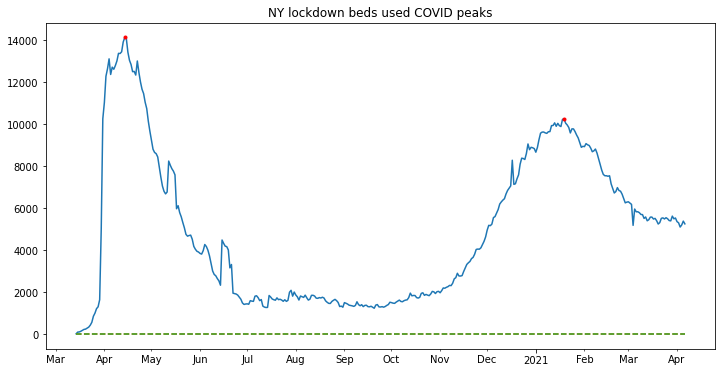

In [16]:
plt.figure(figsize=(12,6))

# Input signal
t = ny_lockdown['date'].values
series =ny_lockdown['inpatient_beds_used_covid'].values

# Threshold value (for height of peaks and valleys)
thresh = 0.95

# Find indices of peaks
peak_idx, _ = find_peaks(series, height=thresh, width=10)

# Find indices of valleys (from inverting the signal)
valley_idx, _ = find_peaks(-series, height=thresh)

# Plot signal
plt.plot(t, series)

# Plot threshold
plt.plot([min(t), max(t)], [thresh, thresh], '--')
plt.plot([min(t), max(t)], [-thresh, -thresh], '--')

# Plot peaks (red) and valleys (blue)
plt.plot(t[peak_idx], series[peak_idx], 'r.')
plt.plot(t[valley_idx], series[valley_idx], 'b.')

# Set the locator
locatorMonths = mdates.MonthLocator()  # every month
locatorYears = mdates.YearLocator()

# Set format
fmtMonths = mdates.DateFormatter('%b')
fmtYears= mdates.DateFormatter('%Y')

X = plt.gca().xaxis
X.set_major_locator(locatorYears)
X.set_minor_locator(locatorMonths)

# Specify formatter
X.set_major_formatter(fmtYears)
X.set_minor_formatter(fmtMonths)

plt.title('NY lockdown beds used COVID peaks')

plt.show()

In [17]:
ny_lockdown.iloc[peak_idx]

,date,inpatient_beds_used_covid
31,2020-04-14,14126.0
311,2021-01-19,10249.0


3 - ¿Cuáles fueron los cinco Estados que más camas UCI -Unidades de Cuidados Intensivos- utilizaron durante el año 2020? La medición debe realizarse en términos absolutos.

In [18]:
df_covid_2020 = df_covid[df_covid['date'] < date(2021,1,1)]
top_5_covid_2020 = df_covid_2020.groupby('state')[['staffed_icu_adult_patients_confirmed_covid','staffed_icu_pediatric_patients_confirmed_covid']].sum().sort_values(by = 'staffed_icu_adult_patients_confirmed_covid',ascending = False).head()
top_5_covid_2020

,staffed_icu_adult_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid
state,,
TX,335836.0,322.0
CA,260865.0,989.0
FL,175859.0,284.0
GA,95596.0,518.0
OH,89483.0,203.0


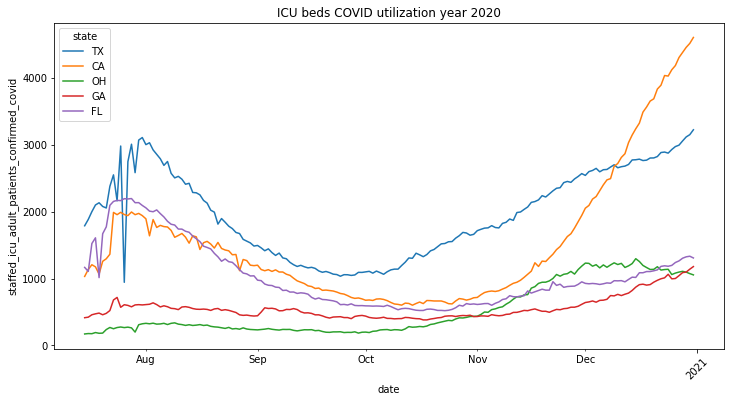

In [19]:
# Visualization
df_top_5 = df_covid_2020[df_covid_2020['state'].isin(top_5_covid_2020.index)]
plt.figure(figsize=(12,6))
sns.lineplot(data = df_top_5,x=df_top_5['date'], y=df_top_5['staffed_icu_adult_patients_confirmed_covid'],hue=df_top_5['state'])

# Set the locator
locatorMonths = mdates.MonthLocator()  # every month
locatorYears = mdates.YearLocator()

# Set format
fmtMonths = mdates.DateFormatter('%b')
fmtYears= mdates.DateFormatter('%Y')

X = plt.gca().xaxis
X.set_major_locator(locatorYears)
X.set_minor_locator(locatorMonths)

# Specify formatter
X.set_major_formatter(fmtYears)
X.set_minor_formatter(fmtMonths)

plt.xticks(rotation=45)

plt.title('ICU beds COVID utilization year 2020')
plt.show()

4 - ¿Qué cantidad de camas se utilizaron, por Estado, para pacientes pediátricos con COVID durante el 2020?

In [20]:
state_pediatric_beds_2020 = df_covid_2020.groupby('state')[['total_pediatric_patients_hospitalized_confirmed_covid']].sum().sort_values(by = 'total_pediatric_patients_hospitalized_confirmed_covid',ascending = False)
state_pediatric_beds_2020.head()

,total_pediatric_patients_hospitalized_confirmed_covid
state,
TX,12525.0
CA,10012.0
FL,7239.0
AZ,5762.0
PA,5686.0


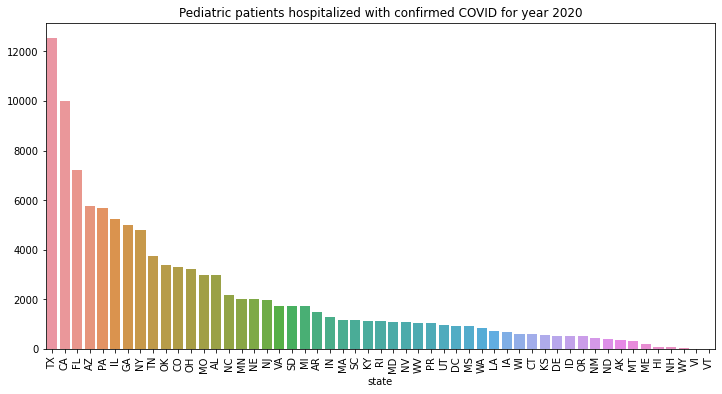

In [21]:
plt.figure(figsize=(12,6))
sns.barplot(x=state_pediatric_beds_2020.index,y=state_pediatric_beds_2020['total_pediatric_patients_hospitalized_confirmed_covid'])
plt.xticks(rotation=90)
plt.title('Pediatric patients hospitalized with confirmed COVID for year 2020')
plt.ylabel('')
plt.show()

5 - ¿Qué porcentaje de camas UCI corresponden a casos confirmados de COVID-19? Agrupe por Estado.

In [22]:
df = df_covid.copy()

In [23]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [24]:
df.groupby(by=['state','year','month'])[['adult_icu_bed_covid_utilization']].mean()#.sort_values(by = 'state')

adult_icu_bed_covid_utilization
state year month                                 
AK    2020 3                                  NaN
           4                                  NaN
           5                                  NaN
           6                                  NaN
           7                             0.062066
...                                           ...
WY    2022 4                             0.000826
           5                             0.008820
           6                             0.022226
           7                             0.027385
           8                             0.025000

[1630 rows x 1 columns]

6 - ¿Cuántas muertes por covid hubo, por Estado, durante el año 2021?

In [25]:
df_covid_2021 = df_covid[(df_covid['date'] >= date(2021,1,1)) & (df_covid['date'] <= date(2021,8,1))]
covid_deaths_2021 = df_covid_2021.groupby('state')[['deaths_covid']].sum().sort_values(by = 'deaths_covid',ascending = False)
covid_deaths_2021

,deaths_covid
state,
CA,24410.0
TX,16174.0
NY,12141.0
FL,10560.0
PA,6551.0
GA,5800.0
NC,5424.0
NJ,4927.0
AZ,4880.0


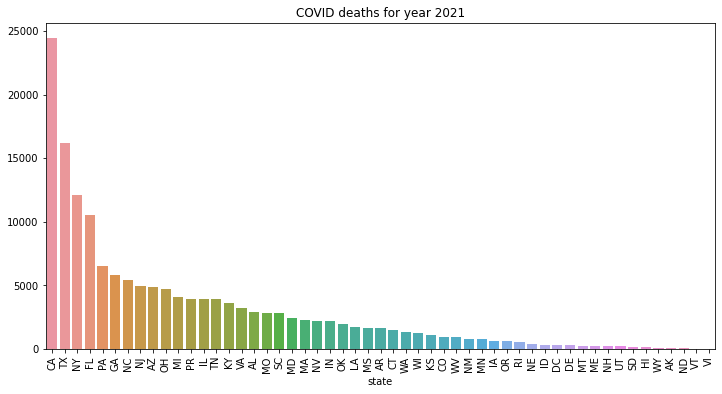

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(x=covid_deaths_2021.index,y=covid_deaths_2021['deaths_covid'])
plt.xticks(rotation=90)
plt.title('COVID deaths for year 2021')
plt.ylabel('')
plt.show()

7 - ¿Qué relación presenta la falta de personal médico, con la cantidad de muertes por covid durante el año 2021?

In [27]:
deaths_covid_byDate = df_covid_2021.groupby(['date'])[['deaths_covid']].sum()
staff_shortage_byDate = df_covid_2021.groupby(['date'])[['critical_staffing_shortage_today_yes']].sum()

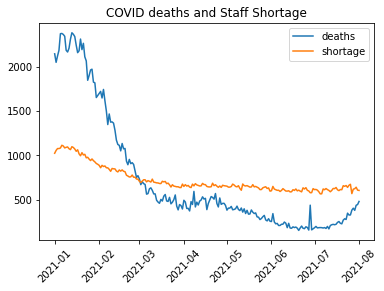

In [28]:
plt.plot(deaths_covid_byDate, label = 'deaths')
plt.plot(staff_shortage_byDate, label = 'shortage')

locatorMonths = mdates.MonthLocator()  # every month

fmtMonths = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_minor_locator(locatorMonths)

plt.title('COVID deaths and Staff Shortage')
plt.xticks(rotation=45)
plt.legend()
plt.show()

8 - Siguiendo las respuestas anteriores, ¿cuál fue el peor mes de la pandemia para USA en su conjunto? Puede utilizar otras medidas que considere necesarias.

In [29]:
covid_totals_sum = df_covid.groupby(['date'])[['deaths_covid','total_covid_confirmed','previous_day_admission_adult_covid_confirmed','critical_staffing_shortage_today_yes','inpatient_beds','inpatient_beds_used_covid']].sum()

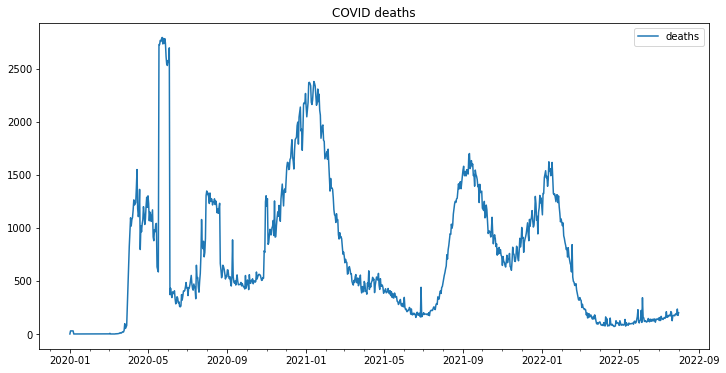

In [30]:
plt.figure(figsize=(12,6))

plt.plot(covid_totals_sum['deaths_covid'], label = 'deaths')

locatorMonths = mdates.MonthLocator()  # every month
fmtMonths = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_minor_locator(locatorMonths)

plt.title('COVID deaths')

plt.legend()
plt.show()

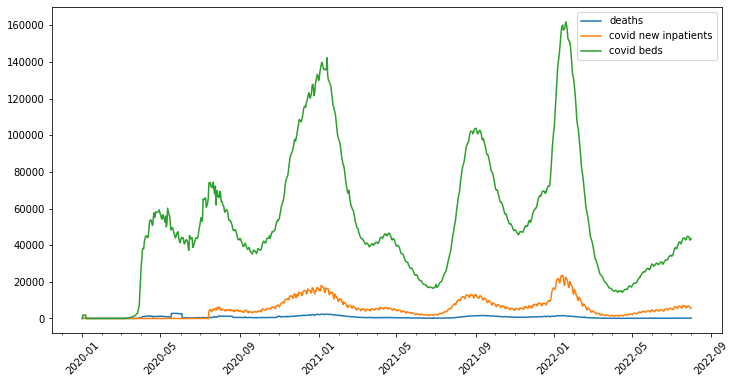

In [32]:
plt.figure(figsize=(12,6))

plt.plot(covid_totals_sum['deaths_covid'], label = 'deaths')
plt.plot(covid_totals_sum['total_covid_confirmed'], label = 'covid new inpatients')
#plt.plot(covid_totals['critical_staffing_shortage_today_yes'], label = 'shortage')
plt.plot(covid_totals_sum['inpatient_beds_used_covid'], label = 'covid beds')

locatorMonths = mdates.MonthLocator()  # every month

fmtMonths = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_minor_locator(locatorMonths)

#plt.title('COVID deaths')
plt.xticks(rotation=45)
plt.legend()
plt.show()